<a href="https://colab.research.google.com/github/DarrelDonald/RL_Snake/blob/master/snake_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
!pip install -q --pre tf-agents[reverb]
!pip install -q 'gym==0.10.11'

In [72]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import numpy as np

from tf_agents.environments import py_environment
from tf_agents.environments import tf_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.environments import wrappers
from tf_agents.environments import suite_gym
from tf_agents.trajectories import time_step as ts


tf.compat.v1.enable_v2_behavior()

In [73]:
FOOD = 3
HEAD = 2
BODY = 1
EMPTY = 0

class SnakeEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=3, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(1, 20, 20), dtype=np.int32, minimum=0, maximum=3, name='observation')
    self._head = (10, 10)
    self._snake = [self._head, (9, 10)]
    self._food = (12, 10)
    self._grid = [[0 for i in range(20)] for j in range(20)]
    self._grid[self._head[1] - 1][self._head[0] - 1] = HEAD
    self._grid[self._food[1] - 1][self._food[0] - 1] = FOOD
    self._grid[self._snake[1][1] - 1][self._snake[1][0] - 1] = BODY
    self._fed = False
    self._moves = 0
    self._survival_time = 0
    self._episode_ended = False

  def action_spec(self):
    return self._action_spec
  
  def render(self):
    dis = [[[0, 0, 0] for i in range(640)] for j in range(640)]
    for i in range(len(self._grid)):
      for j in range(len(self._grid[0])):
        if self._grid[i][j] == 3:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [255, 0, 0]
        elif self._grid[i][j] == 2:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [100, 255, 100]
        elif self._grid[i][j] == 1:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [0, 255, 0]
        else:
          for m in range(32):
            for n in range(32):
              dis[32*i+m][32*j+n] = [255, 255, 255]
    rt = np.asarray(dis, dtype=np.uint8)
    return rt


  def observation_spec(self):
    return self._observation_spec

  def _reset(self):
    self._head = (10, 10)
    self._snake = [self._head, (9, 10)]
    self._food = (12, 10)
    self._grid = [[0 for i in range(20)] for j in range(20)]
    self._grid[self._head[1] - 1][self._head[0] - 1] = HEAD
    self._grid[self._food[1] - 1][self._food[0] - 1] = FOOD
    self._grid[self._snake[1][1] - 1][self._snake[1][0] - 1] = BODY
    self._episode_ended = False
    self._moves = 0
    self._survival_time = 0
    return ts.restart(np.array([self._grid], dtype=np.int32))

  def _step(self, action):
    self._moves += 1
    self._survival_time += 1

    if self._episode_ended:
      # The last action ended the episode. Ignore the current action and start
      # a new episode.
      return self.reset()

    # Make sure episodes don't go on forever.
    if action == 0: # move right
      if self._snake[1] != (self._head[0] + 1, self._head[1]):
        self._head = (self._head[0] + 1, self._head[1])
      else:
        self._head = (self._head[0] - 1, self._head[1])

    elif action == 1: # move left
      if self._snake[1] != (self._head[0] - 1, self._head[1]):
        self._head = (self._head[0] - 1, self._head[1])
      else:
        self._head = (self._head[0] + 1, self._head[1])

    elif action == 2: # move up
      if self._snake[1] != (self._head[0], self._head[1] + 1):
        self._head = (self._head[0], self._head[1] + 1)
      else:
        self._head = (self._head[0], self._head[1] - 1)

    elif action == 3: # move down
      if self._snake[1] != (self._head[0], self._head[1] - 1):
        self._head = (self._head[0], self._head[1] - 1)
      else:
        self._head = (self._head[0], self._head[1] + 1)

    else:
      raise ValueError('`action` should between 0 and 3.')

    
    dist = abs(self._food[0] - self._head[0]) + abs(self._food[1] - self._head[1])
    wall = abs(10 - self._head[0]) + abs(10 - self._head[1])
    
    for i in range(len(self._snake) - 2) :
      if i == self._head:
        self._episode_ended = True
    
    if not 0 <= self._head[0] <= 20 or not 0 <= self._head[1] <= 20:
      self._episode_ended = True

    if self._moves > 800:
      self._episode_ended = True
    
    if self._head == self._food:
      self._fed = True
      self._moves = 0
      # grow snake
      self._snake.append([len(self._snake) - 1])
      # move food
      while self._food in self._snake or self._food == self._head:
        self._food = (np.random.randint(1, 21), np.random.randint(1, 21))

    # move snake
    for i in range(len(self._snake) - 1, 0, -1):
      self._snake[i] = self._snake[i - 1]
    self._snake[0] = self._head
    
    if not self._episode_ended:
      self._grid = [[0 for i in range(20)] for j in range(20)]
      self._grid[self._head[1] - 1][self._head[0] - 1] = HEAD
      self._grid[self._food[1] -1 ][self._food[0] - 1 ] = FOOD
      for i in range(len(self._snake) - 1, 0, -1):
        self._grid[self._snake[i][1] - 1][self._snake[i][0] - 1] = BODY

    reward = len(self._snake) * (40 - dist + self._survival_time - self._moves - wall)
    
    if self._episode_ended:
      return ts.termination(np.array([self._grid], dtype=np.int32), reward)
    else:
      if self._fed:
        self._fed = False
      #else:
        # reward = reward - dist - self._moves
      return ts.transition(
          np.array([self._grid], dtype=np.int32), reward, discount=1)

In [74]:
environment = SnakeEnv()
utils.validate_py_environment(environment, episodes=5)

In [75]:
go_right = np.array(0, dtype=np.int32)

environment = SnakeEnv()
time_step = environment.reset()
print(time_step)
cumulative_reward = time_step.reward

for _ in range(10):
  time_step = environment.step(go_right)
  print(time_step)
  cumulative_reward += time_step.reward

time_step = environment.step(go_right)
print(time_step)
cumulative_reward += time_step.reward
print('Final Reward = ', cumulative_reward)

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [76]:
environment.reset()

TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [77]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents

Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
xvfb is already the newest version (2:1.19.6-1ubuntu4.4).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [78]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

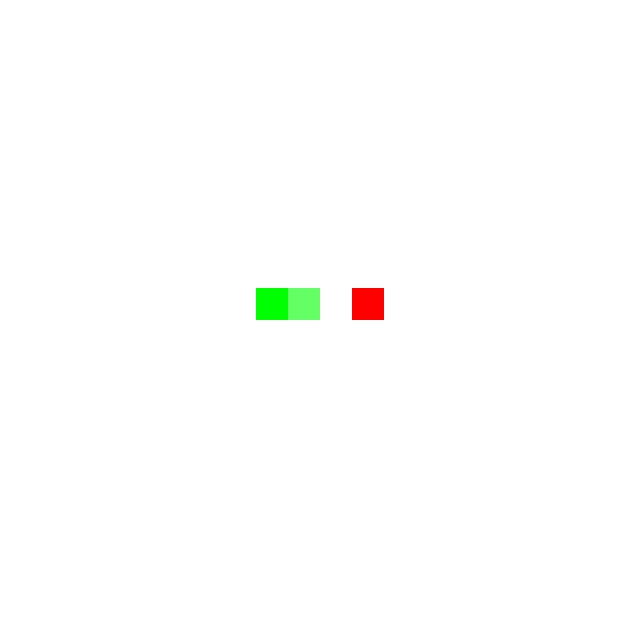

In [79]:
PIL.Image.fromarray(environment.render(), mode='RGB')
#display(img.resize((256, 256), PIL.Image.LANCZOS))

In [104]:
num_iterations = 50000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-4  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

In [81]:
env = environment

print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [82]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int32'), name='action', minimum=0, maximum=3)


In [83]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 

In [84]:
train_py_env = SnakeEnv()
eval_py_env = SnakeEnv()

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

In [85]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [86]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

In [87]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [88]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [89]:
example_environment = tf_py_environment.TFPyEnvironment(
    SnakeEnv())

In [90]:
time_step = example_environment.reset()

In [91]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>, state=(), info=())

In [92]:

def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

In [93]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

3992.1

In [94]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

In [95]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(1, 20, 20), dtype=tf.int32, name='observation', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)), action=BoundedTensorSpec(shape=(), dtype=tf.int32, name='action', minimum=array(0, dtype=int32), maximum=array(3, dtype=int32)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [96]:

def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

In [97]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

<PrefetchDataset shapes: (Trajectory(step_type=(64, 2), observation=(64, 2, 1, 20, 20), action=(64, 2), policy_info=(), next_step_type=(64, 2), reward=(64, 2), discount=(64, 2)), BufferInfo(ids=(64, 2), probabilities=(64,))), types: (Trajectory(step_type=tf.int32, observation=tf.int32, action=tf.int32, policy_info=(), next_step_type=tf.int32, reward=tf.float32, discount=tf.float32), BufferInfo(ids=tf.int64, probabilities=tf.float32))>

In [98]:
iterator = iter(dataset)

print(iterator)


In [105]:

try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs
step = 200: loss = 20114.48046875
step = 400: loss = 12277.94140625
step = 600: loss = 21632.0234375
step = 800: loss = 11246.0048828125
step = 1000: loss = 18427.0859375
step = 1000: Average Return = 2303.89990234375
step = 1200: loss = 18524.015625
step = 1400: loss = 8846.548828125
step = 1600: loss = 22177.12890625
step = 1800: loss = 10461.724609375
step = 2000: loss = 10069.0234375
step = 2000: Average Return = 2544.300048828125
step = 2200: loss = 11069.119140625
step = 2400: loss = 21514.2578125
step = 2600: loss = 17670.603515625
step = 2800: loss = 13007.25
step = 3000: loss = 18162.19140625
step = 3000: Average Return = 1777.5999755859375
step = 3200: loss = 14957.9736328125
step = 3400: loss = 13599.986328125
step = 3600: loss = 20274.029296875
step = 3800: loss = 28430.296875
step = 4000: loss = 15476.6787109375
step = 4000: Average Return = 2058.39990234375
step = 4200: loss = 21282.49609375
step = 4400: loss

Text(0.5, 0, 'Iterations')

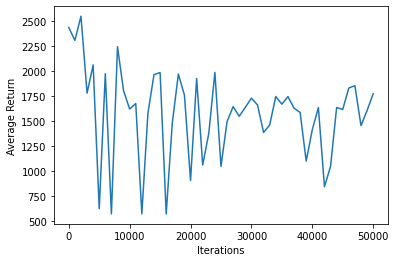

In [106]:


iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

In [101]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [107]:
def create_policy_eval_video(policy, filename, num_episodes=1, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

In [103]:
create_policy_eval_video(random_policy, "random-agent")